<a href="https://colab.research.google.com/github/Shadabur-Rahaman/30-days-ml-projects/blob/main/Day_22_explainable_ai/notebooks/day_22_explainable_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI with SHAP and LIME
This notebook demonstrates how to interpret machine learning models using SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations).

## 1. Import Required Libraries

In [7]:
!pip install lime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Prepare Dataset
We'll use the Heart Disease UCI dataset from Kaggle
Source: [Heart Disease UCI](https://www.kaggle.com/datasets/ronitf/heart-disease-uci)

In [8]:
# Load dataset
df = pd.read_csv('heart.csv')

# Explore dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# Basic info
print("\nDataset info:")
df.info()

Dataset shape: (1025, 14)

First 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


### Dataset Description:
- **age**: Age in years
- **sex**: Sex (1 = male; 0 = female)
- **cp**: Chest pain type (0-3)
- **trestbps**: Resting blood pressure (mm Hg)
- **chol**: Serum cholesterol (mg/dl)
- **fbs**: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- **restecg**: Resting electrocardiographic results (0-2)
- **thalach**: Maximum heart rate achieved
- **exang**: Exercise induced angina (1 = yes; 0 = no)
- **oldpeak**: ST depression induced by exercise relative to rest
- **slope**: Slope of the peak exercise ST segment
- **ca**: Number of major vessels (0-3) colored by fluoroscopy
- **thal**: Thalassemia (3 = normal; 6 = fixed defect; 7 = reversible defect)
- **target**: Presence of heart disease (1 = disease; 0 = no disease)

## 3. Data Preprocessing

In [9]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Prepare features and target
X = df.drop('target', axis=1)
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Training set size: 820 samples
Test set size: 205 samples


## 4. Train a Random Forest Model

In [10]:
# Initialize and train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print(f"Training accuracy: {accuracy_score(y_train, train_preds):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, test_preds):.4f}")

Training accuracy: 1.0000
Test accuracy: 0.9854


## 5. SHAP (SHapley Additive exPlanations) Analysis

In [13]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)


### 5.1 Global Feature Importance

SHAP values shape: (205, 13, 2)
X_test shape: (205, 13)


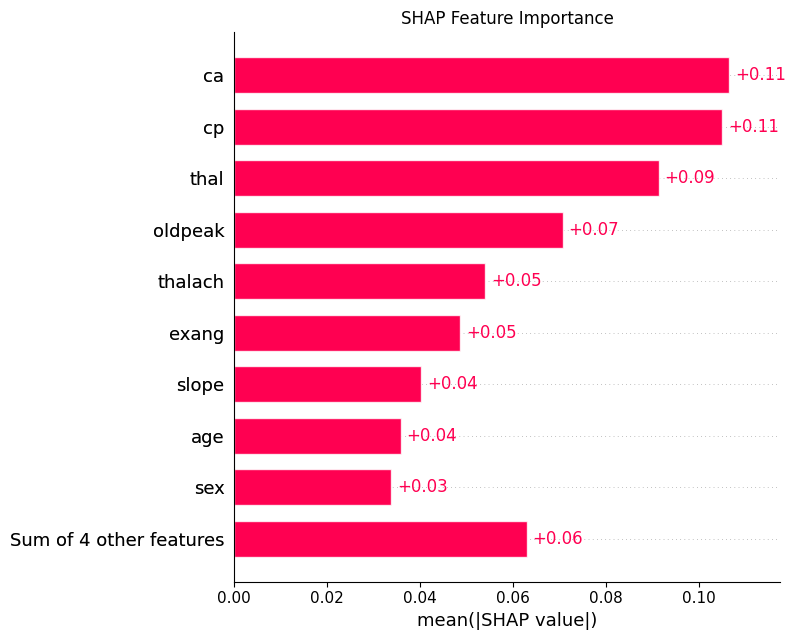

In [14]:
# Summary plot
# Debug information to verify shapes
print(f"SHAP values shape: {shap_values.shape}")
print(f"X_test shape: {X_test.shape}")

# %% [markdown]
# ### 5.1 Global Feature Importance
# Summary plot - use the new API method
shap.plots.bar(shap_values[:,:,1], show=False)  # For class 1 (Heart Disease)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.savefig('shap_feature_importance.png', dpi=300)
plt.show()

### 5.2 Force Plot for Individual Prediction

Sample features:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
590,74,0,1,120,269,0,0,121,1,0.2,2,1,2


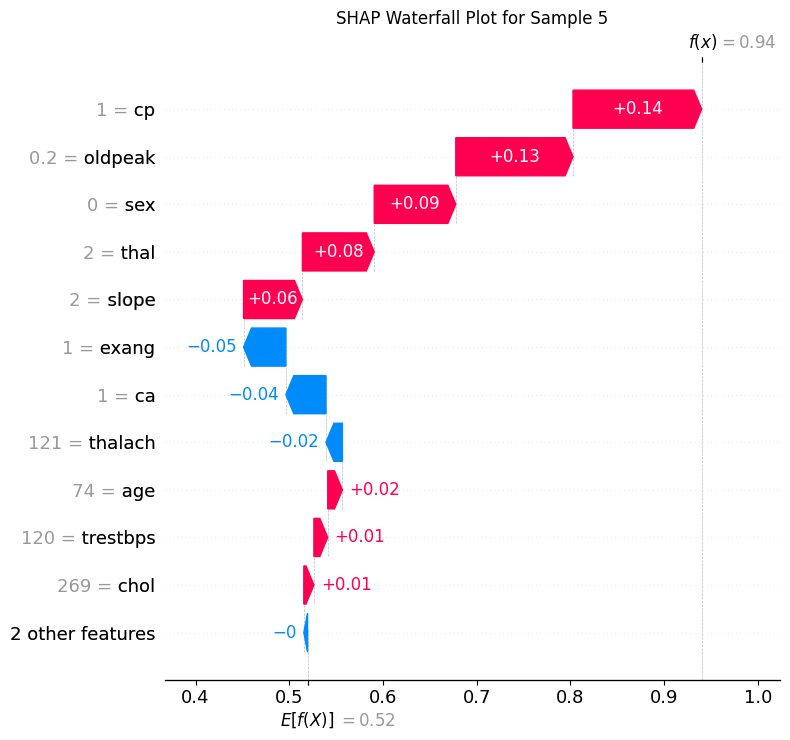

In [16]:
# Select a sample to explain
sample_idx = 5
print("Sample features:")
display(X_test.iloc[sample_idx:sample_idx+1])

# Create waterfall plot
plt.figure()
shap.plots.waterfall(shap_values[sample_idx, :, 1], max_display=12, show=False)
plt.title(f"SHAP Waterfall Plot for Sample {sample_idx}", fontsize=12)
plt.tight_layout()
plt.savefig('shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.3 Dependence Plot

SHAP values shape: (205, 13, 2)
X_test shape: (205, 13)


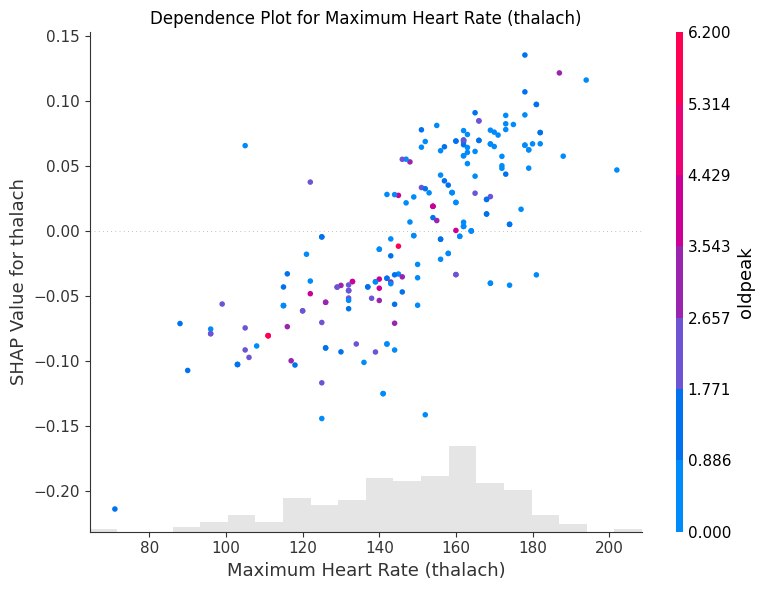

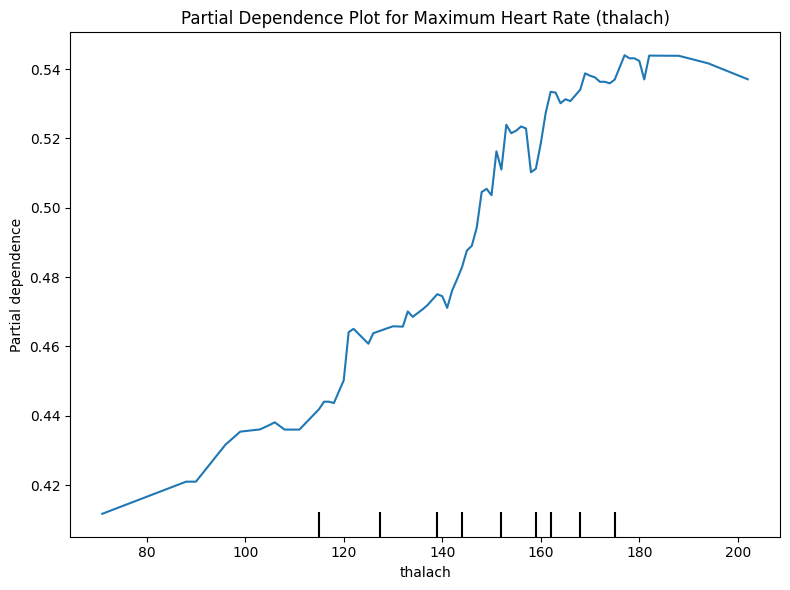

In [21]:
print(f"SHAP values shape: {shap_values.shape}")
print(f"X_test shape: {X_test.shape}")

# Create a DataFrame with SHAP values for class 1
shap_df = pd.DataFrame(shap_values.values[:, :, 1], columns=X_test.columns)

# Create dependence plot using modern API
fig, ax = plt.subplots(figsize=(8, 6))
shap.plots.scatter(
    shap_values[:, "thalach", 1],  # SHAP values for thalach feature (class 1)
    color=shap_values[:, "oldpeak", 1],  # Color by oldpeak SHAP values
    show=False,
    ax=ax
)
ax.set_title("Dependence Plot for Maximum Heart Rate (thalach)")
ax.set_xlabel("Maximum Heart Rate (thalach)")
ax.set_ylabel("SHAP Value for thalach")
plt.tight_layout()
plt.savefig('shap_dependence_plot.png', dpi=300)
plt.show()

from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    features=["thalach"],
    target=1,  # For heart disease class
    ax=ax
)
ax.set_title("Partial Dependence Plot for Maximum Heart Rate (thalach)")
plt.tight_layout()
plt.savefig('pdp_thalach.png', dpi=300)
plt.show()

### 5.4 Decision Plot

Categorical columns: []
Numerical columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Processed feature names: ['num__age' 'num__sex' 'num__cp' 'num__trestbps' 'num__chol' 'num__fbs'
 'num__restecg' 'num__thalach' 'num__exang' 'num__oldpeak' 'num__slope'
 'num__ca' 'num__thal']


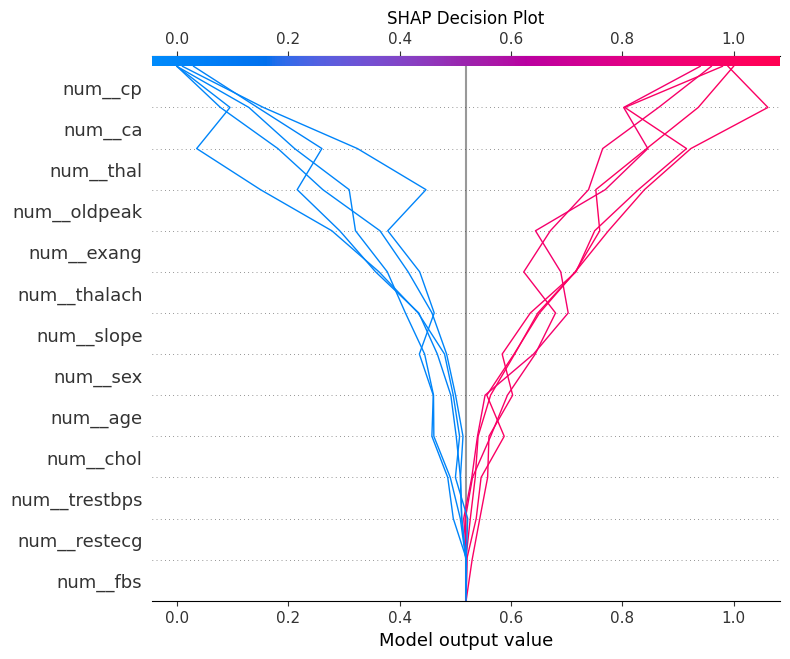

In [36]:
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Identify categorical and numerical columns automatically
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target if present
if 'target' in numerical_cols:
    numerical_cols.remove('target')
if 'target' in categorical_cols:
    categorical_cols.remove('target')

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

# Fit and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names from the preprocessor
try:
    # For sklearn >= 1.0
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # For older sklearn versions
    feature_names = numerical_cols + \
        preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()
    if preprocessor.remainder == 'passthrough':
        passthrough_cols = [col for col in X_train.columns
                            if col not in categorical_cols + numerical_cols]
        feature_names += passthrough_cols

print("Processed feature names:", feature_names)

# Train model on processed data
model.fit(X_train_processed, y_train)

# Create SHAP explainer
shap_explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = shap_explainer(X_test_processed[:10])

# Create decision plot using the new API
shap.decision_plot(
    shap_explainer.expected_value[1],
    shap_values.values[:10, :, 1],  # For class 1
    feature_names=feature_names,
    feature_order='importance',
    show=False
)
plt.title("SHAP Decision Plot")
plt.tight_layout()
plt.savefig('shap_decision_plot.png', dpi=300)
plt.show()

# Create LIME

## 6. LIME (Local Interpretable Model-agnostic Explanations) Analysis

In [37]:
# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No Heart Disease', 'Heart Disease'],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)


### 6.1 Explain a Single Prediction

Sample features:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
590,74,0,1,120,269,0,0,121,1,0.2,2,1,2


Model probabilities: [[0.6 0.4]]
Predicted class index: 0
Actual class: Heart Disease
Predicted class: Heart Disease


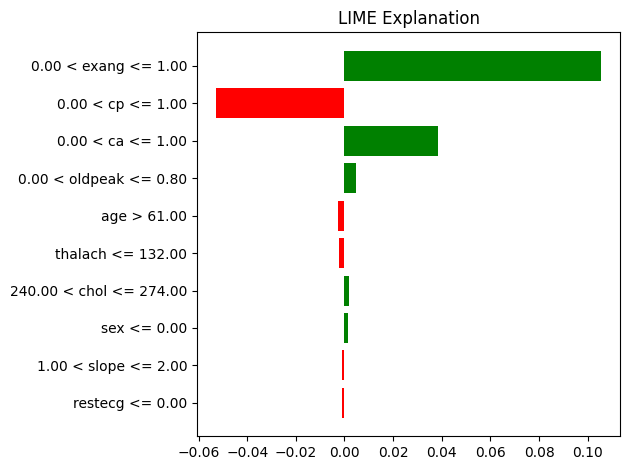

In [40]:
# Select a sample to explain
sample_idx = 5
print("Sample features:")
display(X_test.iloc[sample_idx:sample_idx+1])

# Get model probabilities for the sample
sample_proba = model.predict_proba(X_test.iloc[sample_idx:sample_idx+1])
print("Model probabilities:", sample_proba)

# Find the predicted class index
predicted_class_idx = np.argmax(sample_proba)
print("Predicted class index:", predicted_class_idx)

# Explain prediction with version-safe approach
try:
    # For newer LIME versions
    exp = explainer.explain_instance(
        data_row=X_test.iloc[sample_idx].values,
        predict_fn=model.predict_proba,
        num_features=10,
        top_labels=1
    )

    # Try to get explanation for the predicted class
    try:
        fig = exp.as_pyplot_figure(label=predicted_class_idx)
    except KeyError:
        # Fallback to the first available label
        available_labels = list(exp.available_labels())
        fig = exp.as_pyplot_figure(label=available_labels[0])

except TypeError:
    # For older LIME versions
    exp = explainer.explain_instance(
        data_row=X_test.iloc[sample_idx].values,
        predict_fn=model.predict_proba,
        num_features=10,
        num_samples=5000
    )
    fig = exp.as_pyplot_figure()

# Show explanation
print(f"Actual class: {'Heart Disease' if y_test.iloc[sample_idx] else 'No Heart Disease'}")
print(f"Predicted class: {'Heart Disease' if test_preds[sample_idx] else 'No Heart Disease'}")

# Save and show plot
plt.title("LIME Explanation")
plt.tight_layout()
plt.savefig('lime_explanation.png', dpi=300)
plt.show()

# Show explanation in notebook
exp.show_in_notebook(show_table=True)

### 6.2 Compare Explanations for Different Classes


Correctly classified sample:


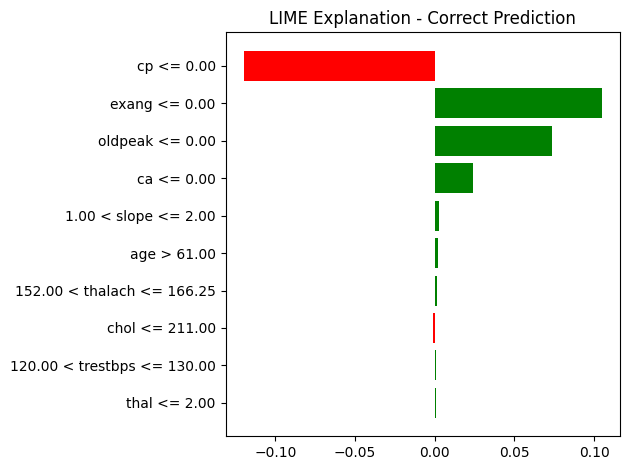


Incorrectly classified sample:


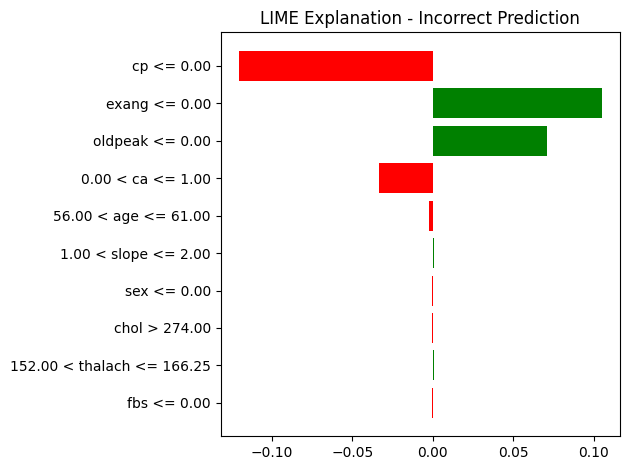

In [41]:
# Select two samples: one correctly predicted, one incorrectly predicted
correct_idx = np.where(test_preds == y_test)[0][0]
incorrect_idx = np.where(test_preds != y_test)[0][0]

print("\nCorrectly classified sample:")
exp_correct = explainer.explain_instance(
    X_test.iloc[correct_idx],
    model.predict_proba,
    num_features=10
)
exp_correct.as_pyplot_figure(label=1)
plt.title("LIME Explanation - Correct Prediction")
plt.tight_layout()
plt.savefig('lime_correct.png', dpi=300)
plt.show()

print("\nIncorrectly classified sample:")
exp_incorrect = explainer.explain_instance(
    X_test.iloc[incorrect_idx],
    model.predict_proba,
    num_features=10
)
exp_incorrect.as_pyplot_figure(label=1)
plt.title("LIME Explanation - Incorrect Prediction")
plt.tight_layout()
plt.savefig('lime_incorrect.png', dpi=300)
plt.show()

## 7. Comparing SHAP and LIME
| **Characteristic**       | **SHAP**                                      | **LIME**                                      |
|--------------------------|-----------------------------------------------|-----------------------------------------------|
| **Approach**             | Game theory (Shapley values)                  | Local surrogate models                        |
| **Scope**                | Global and local explanations                 | Primarily local explanations                  |
| **Consistency**          | Theoretically consistent (additive)           | May have inconsistencies                      |
| **Computation**          | Can be computationally expensive              | Generally faster than SHAP                    |
| **Feature Dependencies** | Can capture complex dependencies              | Treats features as independent                |
| **Visualization**        | Rich visualization options                    | Simpler visualizations                        |
| **Model Support**        | Better for tree-based models                  | Truly model-agnostic                          |
| **Interpretability**     | Values represent log-odds contributions       | Shows feature weights for local approximation |

## 8. Key Takeaways
1. **SHAP**:
   - Provides both global and local explanations
   - Based on solid game theory foundations
   - Excellent visualizations for feature importance
   - Better for understanding model structure

2. **LIME**:
   - Focuses on local interpretability
   - Truly model-agnostic approach
   - Easier to understand for non-experts
   - Faster computation for individual predictions

3. **Use Cases**:
   - Use SHAP for model debugging and feature importance
   - Use LIME for explaining individual predictions to stakeholders
   - Combine both for comprehensive model interpretation

## 9. Save Explanations for Production

In [44]:
import numpy as np
import joblib
import json
import shap

# Get SHAP version
shap_version = shap.__version__
print(f"SHAP version: {shap_version}")

# Save SHAP values
try:
    # For SHAP >= 0.41.0
    shap_values.save('shap_values.h5')
    print("SHAP values saved using Explanation.save()")
except AttributeError:
    # For older versions
    # Save the values, base values, and data separately
    np.save('shap_values.npy', shap_values.values)
    np.save('shap_base_values.npy', shap_values.base_values)
    np.save('shap_data.npy', shap_values.data)

    # Save feature names
    with open('shap_feature_names.json', 'w') as f:
        json.dump(shap_values.feature_names, f)

    print("SHAP values saved in separate numpy files")

# Save SHAP explainer
try:
    joblib.dump(shap_explainer, 'shap_explainer.joblib')
    print("SHAP explainer saved successfully")
except Exception as e:
    print(f"Could not save SHAP explainer: {e}")
    print("Note: Some explainers like KernelExplainer can't be serialized")

# Save LIME configuration
lime_config = {
    'feature_names': list(X.columns),
    'class_names': ['No Heart Disease', 'Heart Disease'],
    'mode': 'classification',
    'categorical_features': categorical_cols if 'categorical_cols' in locals() else [],
    'discretize_continuous': True
}

with open('lime_config.json', 'w') as f:
    json.dump(lime_config, f)

print("LIME configuration saved!")

# Save LIME explainer if possible
try:
    joblib.dump(explainer, 'lime_explainer.joblib')
    print("LIME explainer saved successfully")
except Exception as e:
    print(f"Could not save LIME explainer: {e}")
    print("Note: LIME explainers are not always serializable. You may need to recreate it.")

SHAP version: 0.47.2
SHAP values saved in separate numpy files
SHAP explainer saved successfully
LIME configuration saved!
Could not save LIME explainer: Can't pickle <function BaseDiscretizer.__init__.<locals>.<lambda> at 0x7cf05ea6d580>: it's not found as lime.discretize.BaseDiscretizer.__init__.<locals>.<lambda>
Note: LIME explainers are not always serializable. You may need to recreate it.


In [45]:
import numpy as np
import shap
import json

try:
    # Try loading as Explanation object
    shap_values = shap.Explanation.load('shap_values.h5')
    print("Loaded SHAP Explanation from HDF5 file")
except (FileNotFoundError, AttributeError):
    try:
        # Load from separate files
        values = np.load('shap_values.npy')
        base_values = np.load('shap_base_values.npy')
        data = np.load('shap_data.npy')

        with open('shap_feature_names.json', 'r') as f:
            feature_names = json.load(f)

        # Recreate Explanation object
        shap_values = shap.Explanation(
            values=values,
            base_values=base_values,
            data=data,
            feature_names=feature_names
        )
        print("Reconstructed SHAP Explanation from numpy files")
    except FileNotFoundError:
        print("Error: No SHAP files found")
        shap_values = None

# Reload explainer if saved
try:
    shap_explainer = joblib.load('shap_explainer.joblib')
    print("Loaded SHAP explainer")
except FileNotFoundError:
    print("SHAP explainer file not found")
    shap_explainer = None

Reconstructed SHAP Explanation from numpy files
Loaded SHAP explainer
